# Neural Net + Delta and Vega FD

Running on: cuda
train 4,743,506 rows
valid 47,915 rows


c:\Users\jacks\anaconda3\envs\tf-gpu\lib\site-packages\torch\autograd\graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[upd 1/100000] train loss=1.436e-01  val loss=2.315e-01
[upd 5000/100000] train loss=1.861e-03  val loss=1.983e-03
[upd 10000/100000] train loss=1.967e-03  val loss=2.243e-03
[upd 15000/100000] train loss=1.290e-03  val loss=1.378e-03
[upd 20000/100000] train loss=1.379e-03  val loss=1.422e-03
[upd 25000/100000] train loss=1.329e-03  val loss=1.332e-03
[upd 30000/100000] train loss=1.529e-03  val loss=1.445e-03
[upd 35000/100000] train loss=1.458e-03  val loss=1.381e-03
[upd 40000/100000] train loss=1.358e-03  val loss=1.370e-03
[upd 45000/100000] train loss=1.453e-03  val loss=1.368e-03
[upd 50000/100000] train loss=1.445e-03  val loss=1.276e-03
[upd 55000/100000] train loss=1.259e-03  val loss=1.299e-03
[upd 60000/100000] train loss=1.410e-03  val loss=1.467e-03
[upd 65000/100000] train loss=1.175e-03  val loss=1.260e-03
[upd 70000/100000] train loss=1.248e-03  val loss=1.271e-03
[upd 75000/100000] train loss=1.433e-03  val loss=1.354e-03
[upd 80000/100000] train loss=1.495e-03  val 

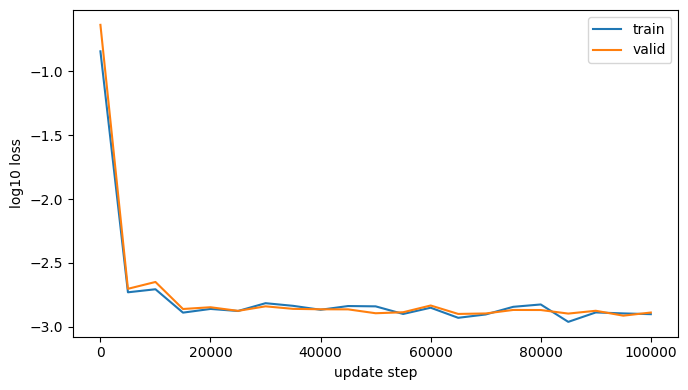


Test set performance:
   Price: MAE=4.459e-03, RMSE=7.344e-03, R²=0.9992


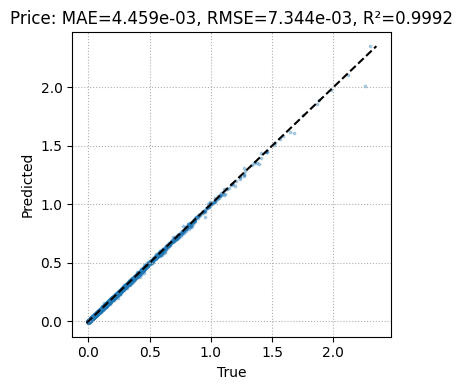

 Delta_0: MAE=9.942e-03, RMSE=1.772e-02, R²=0.9916


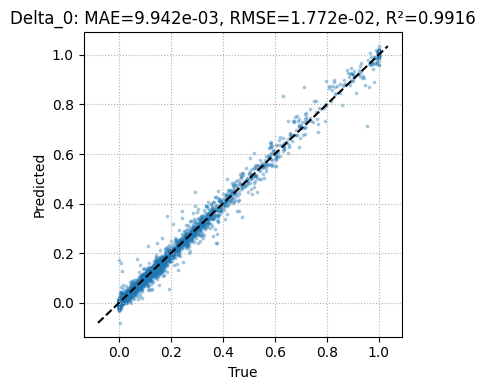

 Delta_1: MAE=9.907e-03, RMSE=1.829e-02, R²=0.9914


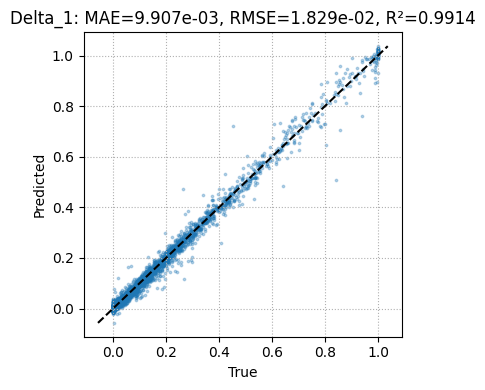

 Delta_2: MAE=1.019e-02, RMSE=1.867e-02, R²=0.9907


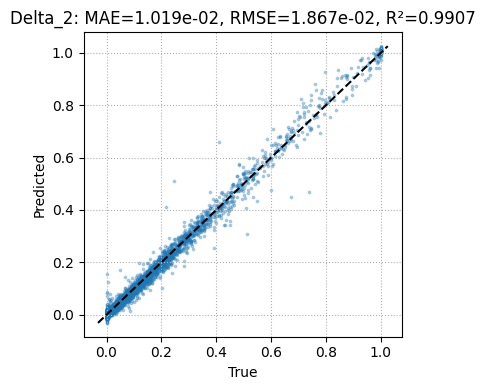

  Vega_0: MAE=1.787e-02, RMSE=3.371e-02, R²=0.9690


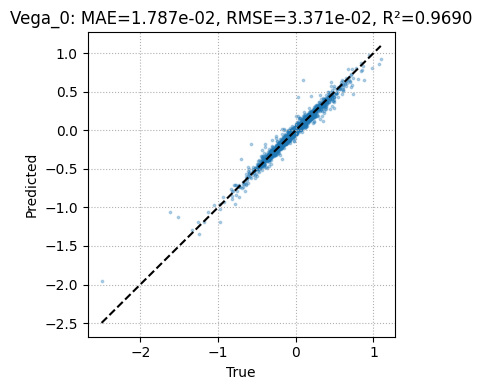

  Vega_1: MAE=1.715e-02, RMSE=3.365e-02, R²=0.9655


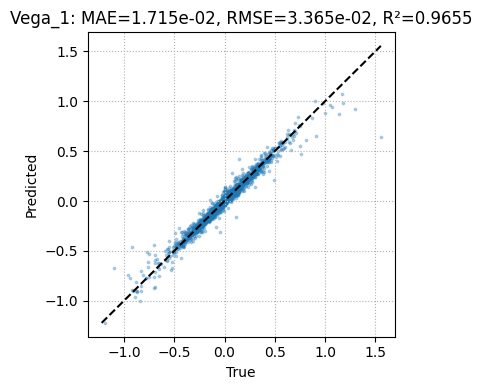

  Vega_2: MAE=1.705e-02, RMSE=3.014e-02, R²=0.9743


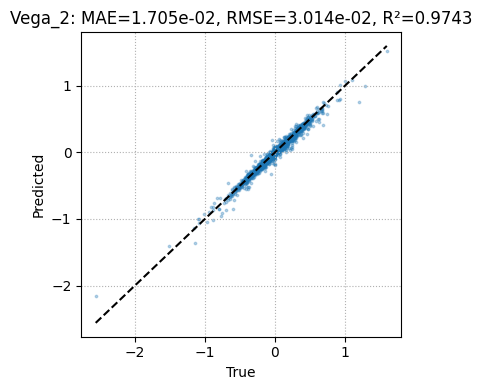

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# 1) Device & seeds
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", DEVICE)
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# 2) Load dataset with price and FD Greeks
df = pd.read_parquet("Train_clean_5m_fd_greeks.parquet", engine="pyarrow")

# 3) Define target and feature columns
target_cols = ["price/k"] + [f"delta_{i}" for i in range(3)] + [f"vega_{i}" for i in range(3)]
feature_cols = [c for c in df.columns if c not in target_cols]

# 4) Extract NumPy arrays
X = df[feature_cols].values.astype(np.float32)
y = df[target_cols].values.astype(np.float32)

# 5) Train/val split (99/1)
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.01, random_state=42)

# 6) Separate price, delta, vega targets
price_tr, delta_tr, vega_tr = y_tr[:,0], y_tr[:,1:4], y_tr[:,4:7]
price_val, delta_val, vega_val = y_val[:,0], y_val[:,1:4], y_val[:,4:7]

# 7) Build PyTorch datasets
train_ds = TensorDataset(
    torch.from_numpy(X_tr),
    torch.from_numpy(price_tr),
    torch.from_numpy(delta_tr),
    torch.from_numpy(vega_tr)
)
val_ds = TensorDataset(
    torch.from_numpy(X_val),
    torch.from_numpy(price_val),
    torch.from_numpy(delta_val),
    torch.from_numpy(vega_val)
)
print(f"train {len(train_ds):,} rows")
print(f"valid {len(val_ds):,} rows")

# 8) Define single-output BasketNet model
class BasketNet(nn.Module):
    def __init__(self, in_dim, width=300, layers=4):
        super().__init__()
        blocks = [nn.Linear(in_dim, width), nn.ReLU()]
        for _ in range(layers-1):
            blocks += [nn.Linear(width, width), nn.ReLU()]
        blocks.append(nn.Linear(width, 1))
        self.net = nn.Sequential(*blocks)
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        return self.net(x).squeeze(1)  # (batch,)

# 9) Feature indices for Greeks
delta_idx = [feature_cols.index(f"S0_{i}/K") for i in range(3)]
vega_idx  = [feature_cols.index(f"sigma_{i}") for i in range(3)]

# 10) Training loop with Sobolev (differential) loss
def run_differential(
    width=300,
    layers=4,
    batch_size=50_000,
    n_updates=100_000,
    lr=1e-3,
    λ=1.0,
    log_every=5_000
):
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, pin_memory=True)

    model     = BasketNet(len(feature_cols), width, layers).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    train_losses, valid_losses, steps = [], [], []

    # infinite iterator for training
    def inf_iter(loader):
        while True:
            for batch in loader:
                yield batch
    train_iter = inf_iter(train_loader)

    model.train()
    for step in range(1, n_updates+1):
        Xb, p_true, d_true, v_true = next(train_iter)
        Xb = Xb.to(DEVICE).requires_grad_(True)
        p_true, d_true, v_true = [t.to(DEVICE) for t in (p_true, d_true, v_true)]

        optimizer.zero_grad()

        # forward price
        p_pred = model(Xb)
        loss_p = criterion(p_pred, p_true)

        # compute autograd Greeks (retain graph for Sobolev loss)
        grad = torch.autograd.grad(
            outputs=p_pred,
            inputs=Xb,
            grad_outputs=torch.ones_like(p_pred),
            create_graph=True
        )[0]
        # extract predictions
        d_pred = grad[:, delta_idx]
        v_pred = grad[:, vega_idx]
        loss_g = criterion(d_pred, d_true) + criterion(v_pred, v_true)

        # total loss
        loss = loss_p + λ * loss_g
        loss.backward()
        optimizer.step()

        # validation & logging
        if step == 1 or step % log_every == 0 or step == n_updates:
            model.eval()
            tot_val, cnt = 0.0, 0
            for Xv, pv, dv, vv in val_loader:
                Xv = Xv.to(DEVICE).requires_grad_(True)
                pv, dv, vv = [t.to(DEVICE) for t in (pv, dv, vv)]

                pp = model(Xv)
                lp = criterion(pp, pv)

                g = torch.autograd.grad(
                    outputs=pp,
                    inputs=Xv,
                    grad_outputs=torch.ones_like(pp),
                    create_graph=False
                )[0]
                lg = criterion(g[:, delta_idx], dv) + criterion(g[:, vega_idx], vv)

                tot_val += (lp + λ * lg).item() * Xv.size(0)
                cnt     += Xv.size(0)

            val_loss = tot_val / cnt
            train_losses.append(loss.item())
            valid_losses.append(val_loss)
            steps.append(step)
            print(f"[upd {step}/{n_updates}] train loss={loss.item():.3e}  val loss={val_loss:.3e}")
            model.train()

    # plot training curves
    plt.figure(figsize=(7,4))
    plt.plot(steps, np.log10(train_losses), label="train")
    plt.plot(steps, np.log10(valid_losses), label="valid")
    plt.xlabel("update step")
    plt.ylabel("log10 loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model

# 11) Run training
model = run_differential(
    width=250,
    layers=5,
    batch_size=5_000,
    n_updates=100_000,
    lr=1e-3,
    λ=1.0,
    log_every=5_000
)

# 12) Test evaluation
# load test data
test_df = pd.read_parquet("Test_clean_5k_aad_greeks.parquet", engine="pyarrow")
X_test = torch.from_numpy(test_df[feature_cols].values.astype(np.float32)).to(DEVICE).requires_grad_(True)
y_test = test_df[target_cols].values.astype(np.float32)

model.eval()
# forward pass
p_pred_tensor = model(X_test)
# compute AAD Greeks
grad_test = torch.autograd.grad(
    outputs=p_pred_tensor,
    inputs=X_test,
    grad_outputs=torch.ones_like(p_pred_tensor)
)[0]

# convert to numpy
price_pred = p_pred_tensor.detach().cpu().numpy()
delta_pred = grad_test[:, delta_idx].detach().cpu().numpy()
vega_pred  = grad_test[:, vega_idx].detach().cpu().numpy()

# true targets
p_true = y_test[:, 0]
d_true = y_test[:, 1:4]
v_true = y_test[:, 4:7]

# 13) Metrics & plots
def report_and_plot(name, pred, true):
    mae  = np.mean(np.abs(pred - true))
    rmse = np.sqrt(np.mean((pred - true)**2))
    r2   = np.corrcoef(pred, true)[0,1]**2
    print(f"{name:>8s}: MAE={mae:.3e}, RMSE={rmse:.3e}, R²={r2:.4f}")
    plt.figure(figsize=(4,4))
    plt.scatter(true, pred, s=3, alpha=0.3)
    lo, hi = min(true.min(), pred.min()), max(true.max(), pred.max())
    plt.plot([lo,hi],[lo,hi],'k--')
    plt.title(f"{name}: MAE={mae:.3e}, RMSE={rmse:.3e}, R²={r2:.4f}")
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.grid(ls=":")
    plt.tight_layout()
    plt.show()

print("\nTest set performance:")
report_and_plot("Price", price_pred, p_true)
for i in range(3):
    report_and_plot(f"Delta_{i}", delta_pred[:, i], d_true[:, i])
for i in range(3):
    report_and_plot(f"Vega_{i}",  vega_pred[:, i], v_true[:, i])



# Neural Net + Delta and Vega AAD

## Relu

Running on: cuda
train 4,743,506 rows
valid 47,915 rows
[upd 1/100000] train loss=1.436e-01  val loss=2.315e-01
[upd 5000/100000] train loss=1.983e-03  val loss=2.006e-03
[upd 10000/100000] train loss=2.082e-03  val loss=2.167e-03
[upd 15000/100000] train loss=1.469e-03  val loss=1.529e-03
[upd 20000/100000] train loss=1.326e-03  val loss=1.391e-03
[upd 25000/100000] train loss=1.417e-03  val loss=1.312e-03
[upd 30000/100000] train loss=1.639e-03  val loss=1.443e-03
[upd 35000/100000] train loss=1.418e-03  val loss=1.341e-03
[upd 40000/100000] train loss=1.410e-03  val loss=1.396e-03
[upd 45000/100000] train loss=1.400e-03  val loss=1.336e-03
[upd 50000/100000] train loss=1.443e-03  val loss=1.264e-03
[upd 55000/100000] train loss=1.372e-03  val loss=1.376e-03
[upd 60000/100000] train loss=1.307e-03  val loss=1.324e-03
[upd 65000/100000] train loss=1.243e-03  val loss=1.425e-03
[upd 70000/100000] train loss=1.236e-03  val loss=1.235e-03
[upd 75000/100000] train loss=1.245e-03  val loss

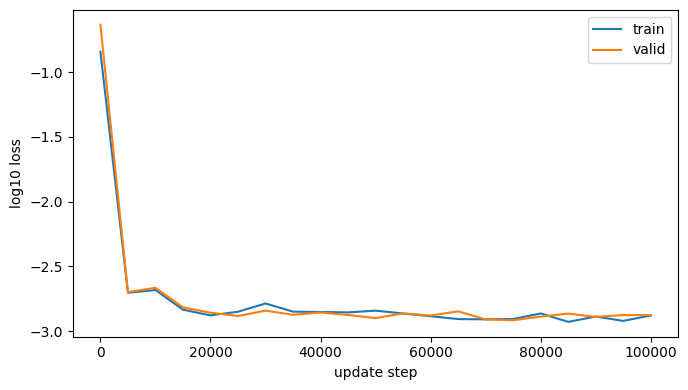


Test set performance:
   Price: MAE=5.255e-03, RMSE=7.787e-03, R²=0.9993


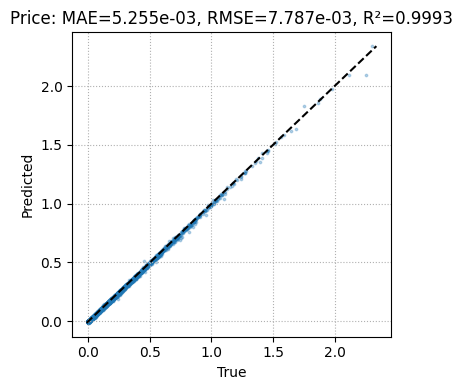

 Delta_0: MAE=9.957e-03, RMSE=1.726e-02, R²=0.9919


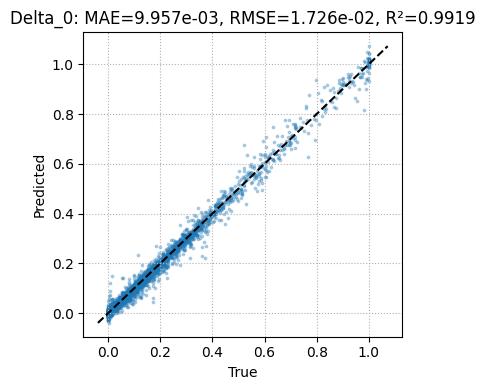

 Delta_1: MAE=9.851e-03, RMSE=1.768e-02, R²=0.9919


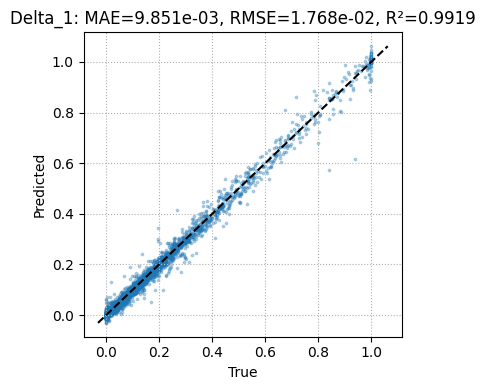

 Delta_2: MAE=9.838e-03, RMSE=1.742e-02, R²=0.9918


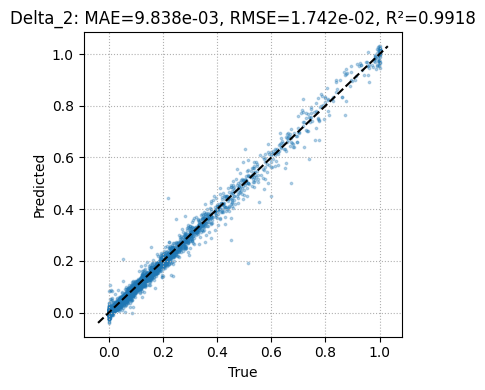

  Vega_0: MAE=1.789e-02, RMSE=3.375e-02, R²=0.9689


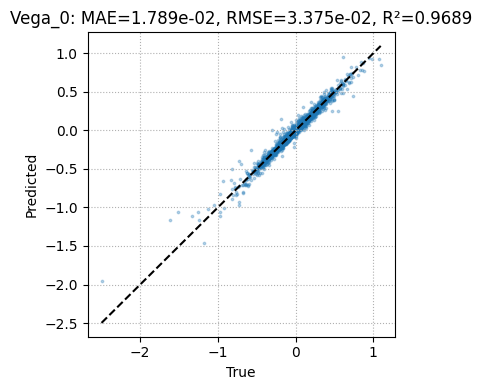

  Vega_1: MAE=1.712e-02, RMSE=3.237e-02, R²=0.9678


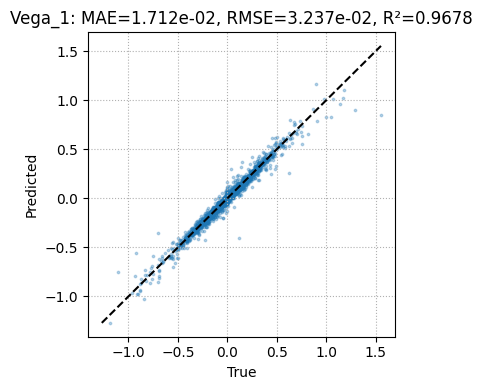

  Vega_2: MAE=1.725e-02, RMSE=3.107e-02, R²=0.9725


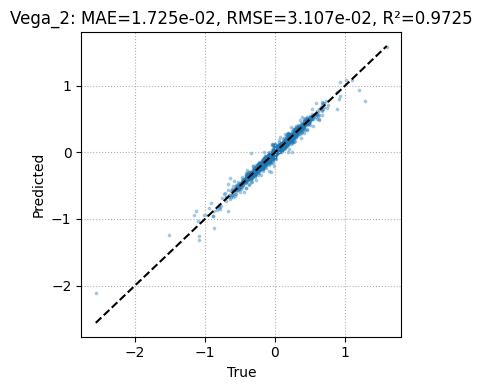

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# 1) Device & seeds
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", DEVICE)
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# 2) Load dataset with price and FD Greeks
df = pd.read_parquet("Train_clean_5m_aad_greeks.parquet", engine="pyarrow")

# 3) Define target and feature columns
target_cols = ["price/k"] + [f"delta_{i}" for i in range(3)] + [f"vega_{i}" for i in range(3)]
feature_cols = [c for c in df.columns if c not in target_cols]

# 4) Extract NumPy arrays
X = df[feature_cols].values.astype(np.float32)
y = df[target_cols].values.astype(np.float32)

# 5) Train/val split (99/1)
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.01, random_state=42)

# 6) Separate price, delta, vega targets
price_tr, delta_tr, vega_tr = y_tr[:,0], y_tr[:,1:4], y_tr[:,4:7]
price_val, delta_val, vega_val = y_val[:,0], y_val[:,1:4], y_val[:,4:7]

# 7) Build PyTorch datasets
train_ds = TensorDataset(
    torch.from_numpy(X_tr),
    torch.from_numpy(price_tr),
    torch.from_numpy(delta_tr),
    torch.from_numpy(vega_tr)
)
val_ds = TensorDataset(
    torch.from_numpy(X_val),
    torch.from_numpy(price_val),
    torch.from_numpy(delta_val),
    torch.from_numpy(vega_val)
)
print(f"train {len(train_ds):,} rows")
print(f"valid {len(val_ds):,} rows")

# 8) Define single-output BasketNet model
class BasketNet(nn.Module):
    def __init__(self, in_dim, width=300, layers=4):
        super().__init__()
        blocks = [nn.Linear(in_dim, width), nn.ReLU()]
        for _ in range(layers-1):
            blocks += [nn.Linear(width, width), nn.ReLU()]
        blocks.append(nn.Linear(width, 1))
        self.net = nn.Sequential(*blocks)
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        return self.net(x).squeeze(1)  # (batch,)

# 9) Feature indices for Greeks
delta_idx = [feature_cols.index(f"S0_{i}/K") for i in range(3)]
vega_idx  = [feature_cols.index(f"sigma_{i}") for i in range(3)]

# 10) Training loop with Sobolev (differential) loss
def run_differential(
    width=300,
    layers=4,
    batch_size=50_000,
    n_updates=100_000,
    lr=1e-3,
    λ=1.0,
    log_every=5_000
):
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, pin_memory=True)

    model     = BasketNet(len(feature_cols), width, layers).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    train_losses, valid_losses, steps = [], [], []

    # infinite iterator for training
    def inf_iter(loader):
        while True:
            for batch in loader:
                yield batch
    train_iter = inf_iter(train_loader)

    model.train()
    for step in range(1, n_updates+1):
        Xb, p_true, d_true, v_true = next(train_iter)
        Xb = Xb.to(DEVICE).requires_grad_(True)
        p_true, d_true, v_true = [t.to(DEVICE) for t in (p_true, d_true, v_true)]

        optimizer.zero_grad()

        # forward price
        p_pred = model(Xb)
        loss_p = criterion(p_pred, p_true)

        # compute autograd Greeks (retain graph for Sobolev loss)
        grad = torch.autograd.grad(
            outputs=p_pred,
            inputs=Xb,
            grad_outputs=torch.ones_like(p_pred),
            create_graph=True
        )[0]
        # extract predictions
        d_pred = grad[:, delta_idx]
        v_pred = grad[:, vega_idx]
        loss_g = criterion(d_pred, d_true) + criterion(v_pred, v_true)

        # total loss
        loss = loss_p + λ * loss_g
        loss.backward()
        optimizer.step()

        # validation & logging
        if step == 1 or step % log_every == 0 or step == n_updates:
            model.eval()
            tot_val, cnt = 0.0, 0
            for Xv, pv, dv, vv in val_loader:
                Xv = Xv.to(DEVICE).requires_grad_(True)
                pv, dv, vv = [t.to(DEVICE) for t in (pv, dv, vv)]

                pp = model(Xv)
                lp = criterion(pp, pv)

                g = torch.autograd.grad(
                    outputs=pp,
                    inputs=Xv,
                    grad_outputs=torch.ones_like(pp),
                    create_graph=False
                )[0]
                lg = criterion(g[:, delta_idx], dv) + criterion(g[:, vega_idx], vv)

                tot_val += (lp + λ * lg).item() * Xv.size(0)
                cnt     += Xv.size(0)

            val_loss = tot_val / cnt
            train_losses.append(loss.item())
            valid_losses.append(val_loss)
            steps.append(step)
            print(f"[upd {step}/{n_updates}] train loss={loss.item():.3e}  val loss={val_loss:.3e}")
            model.train()

    # plot training curves
    plt.figure(figsize=(7,4))
    plt.plot(steps, np.log10(train_losses), label="train")
    plt.plot(steps, np.log10(valid_losses), label="valid")
    plt.xlabel("update step")
    plt.ylabel("log10 loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model

# 11) Run training
model = run_differential(
    width=250,
    layers=5,
    batch_size=5_000,
    n_updates=100_000,
    lr=1e-3,
    λ=1.0,
    log_every=5_000
)

# 12) Test evaluation
# load test data
test_df = pd.read_parquet("Test_clean_5k_aad_greeks.parquet", engine="pyarrow")
X_test = torch.from_numpy(test_df[feature_cols].values.astype(np.float32)).to(DEVICE).requires_grad_(True)
y_test = test_df[target_cols].values.astype(np.float32)

model.eval()
# forward pass
p_pred_tensor = model(X_test)
# compute AAD Greeks
grad_test = torch.autograd.grad(
    outputs=p_pred_tensor,
    inputs=X_test,
    grad_outputs=torch.ones_like(p_pred_tensor)
)[0]

# convert to numpy
price_pred = p_pred_tensor.detach().cpu().numpy()
delta_pred = grad_test[:, delta_idx].detach().cpu().numpy()
vega_pred  = grad_test[:, vega_idx].detach().cpu().numpy()

# true targets
p_true = y_test[:, 0]
d_true = y_test[:, 1:4]
v_true = y_test[:, 4:7]

# 13) Metrics & plots
def report_and_plot(name, pred, true):
    mae  = np.mean(np.abs(pred - true))
    rmse = np.sqrt(np.mean((pred - true)**2))
    r2   = np.corrcoef(pred, true)[0,1]**2
    print(f"{name:>8s}: MAE={mae:.3e}, RMSE={rmse:.3e}, R²={r2:.4f}")
    plt.figure(figsize=(4,4))
    plt.scatter(true, pred, s=3, alpha=0.3)
    lo, hi = min(true.min(), pred.min()), max(true.max(), pred.max())
    plt.plot([lo,hi],[lo,hi],'k--')
    plt.title(f"{name}: MAE={mae:.3e}, RMSE={rmse:.3e}, R²={r2:.4f}")
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.grid(ls=":")
    plt.tight_layout()
    plt.show()

print("\nTest set performance:")
report_and_plot("Price", price_pred, p_true)
for i in range(3):
    report_and_plot(f"Delta_{i}", delta_pred[:, i], d_true[:, i])
for i in range(3):
    report_and_plot(f"Vega_{i}",  vega_pred[:, i], v_true[:, i])



## Softplus

Running on: cuda
train 4,743,506 rows
valid 47,915 rows
[upd 1/100000] train loss=9.298e-01  val loss=6.470e+00
[upd 5000/100000] train loss=3.749e-02  val loss=3.728e-02
[upd 10000/100000] train loss=1.488e-02  val loss=1.657e-02
[upd 15000/100000] train loss=6.171e-03  val loss=6.326e-03
[upd 20000/100000] train loss=1.647e-03  val loss=1.769e-03
[upd 25000/100000] train loss=8.978e-04  val loss=8.234e-04
[upd 30000/100000] train loss=6.526e-04  val loss=6.168e-04
[upd 35000/100000] train loss=2.100e-04  val loss=2.152e-04
[upd 40000/100000] train loss=2.016e-04  val loss=1.848e-04
[upd 45000/100000] train loss=1.350e-04  val loss=1.502e-04
[upd 50000/100000] train loss=1.375e-04  val loss=1.263e-04
[upd 55000/100000] train loss=1.160e-04  val loss=1.148e-04
[upd 60000/100000] train loss=8.178e-05  val loss=1.070e-04
[upd 65000/100000] train loss=1.153e-04  val loss=9.223e-05
[upd 70000/100000] train loss=1.028e-04  val loss=1.261e-04
[upd 75000/100000] train loss=6.828e-05  val loss

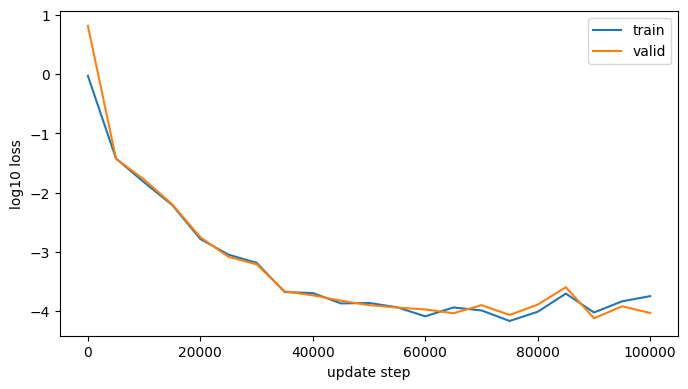


Test set performance:
   Price: MAE=4.400e-03, RMSE=4.921e-03, R²=0.9999


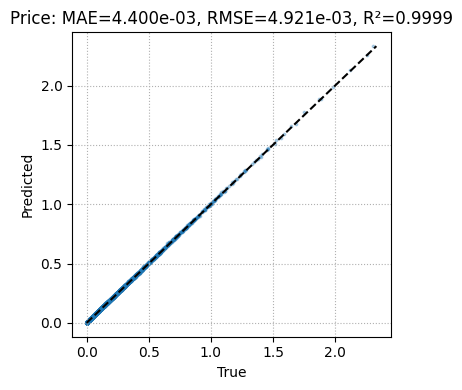

 Delta_0: MAE=1.932e-03, RMSE=4.133e-03, R²=0.9996


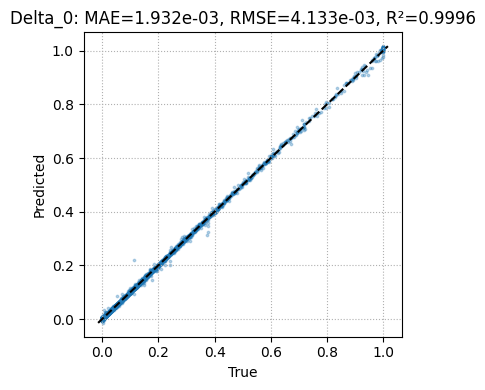

 Delta_1: MAE=2.547e-03, RMSE=5.803e-03, R²=0.9991


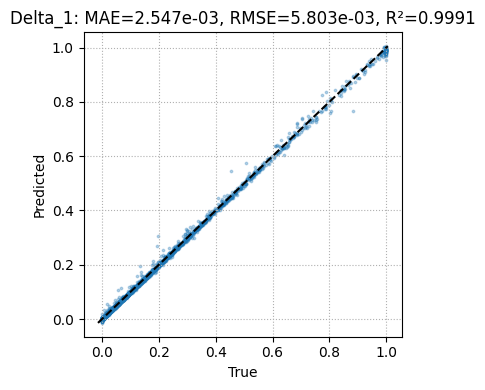

 Delta_2: MAE=1.995e-03, RMSE=3.829e-03, R²=0.9996


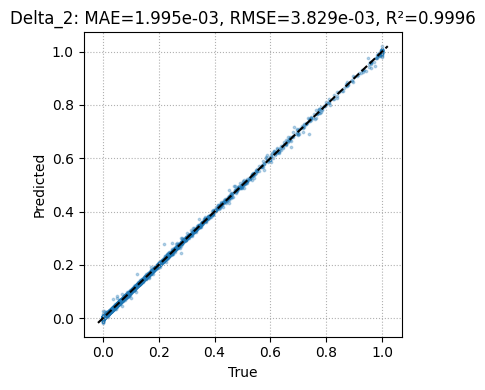

  Vega_0: MAE=3.029e-03, RMSE=5.470e-03, R²=0.9992


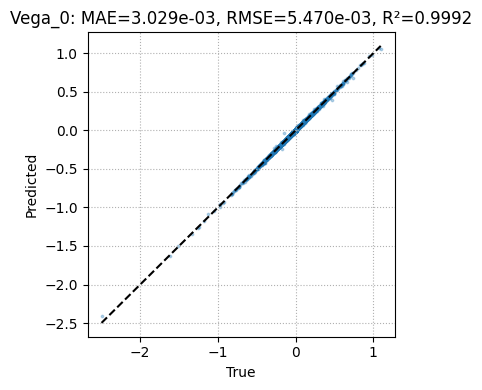

  Vega_1: MAE=3.273e-03, RMSE=6.915e-03, R²=0.9985


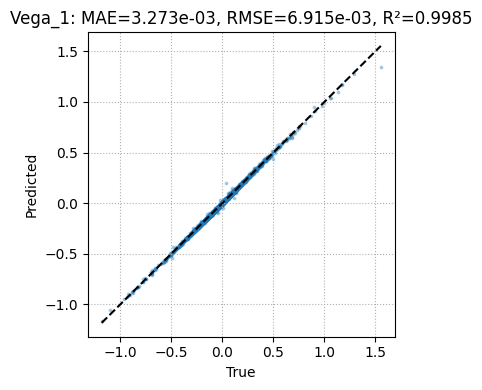

  Vega_2: MAE=3.396e-03, RMSE=6.344e-03, R²=0.9989


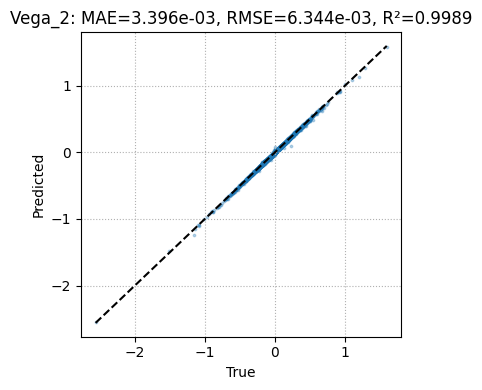

Saved: Test_clean_5k_NN.parquet  and  Train_clean_5k_NN.parquet


In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# 1) Device & seeds
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", DEVICE)
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# 2) Load dataset with price and FD Greeks
df = pd.read_parquet("Train_clean_5m_aad_greeks.parquet", engine="pyarrow")

# 3) Define target and feature columns
target_cols = ["price/k"] + [f"delta_{i}" for i in range(3)] + [f"vega_{i}" for i in range(3)]
feature_cols = [c for c in df.columns if c not in target_cols]

# 4) Extract NumPy arrays
X = df[feature_cols].values.astype(np.float32)
y = df[target_cols].values.astype(np.float32)

# 5) Train/val split (99/1)
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.01, random_state=42)

# 6) Separate price, delta, vega targets
price_tr, delta_tr, vega_tr = y_tr[:,0], y_tr[:,1:4], y_tr[:,4:7]
price_val, delta_val, vega_val = y_val[:,0], y_val[:,1:4], y_val[:,4:7]

# 7) Build PyTorch datasets
train_ds = TensorDataset(
    torch.from_numpy(X_tr),
    torch.from_numpy(price_tr),
    torch.from_numpy(delta_tr),
    torch.from_numpy(vega_tr)
)
val_ds = TensorDataset(
    torch.from_numpy(X_val),
    torch.from_numpy(price_val),
    torch.from_numpy(delta_val),
    torch.from_numpy(vega_val)
)
print(f"train {len(train_ds):,} rows")
print(f"valid {len(val_ds):,} rows")

# 8) Define single-output BasketNet model with Softplus activations
class BasketNet(nn.Module):
    def __init__(self, in_dim, width=300, layers=4):
        super().__init__()
        blocks = [nn.Linear(in_dim, width), nn.Softplus()]
        for _ in range(layers - 1):
            blocks += [nn.Linear(width, width), nn.Softplus()]
        blocks.append(nn.Linear(width, 1))
        self.net = nn.Sequential(*blocks)
        # Xavier init for all Linear layers
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        # returns shape (batch,)
        return self.net(x).squeeze(1)

# 9) Feature indices for Greeks
delta_idx = [feature_cols.index(f"S0_{i}/K") for i in range(3)]
vega_idx  = [feature_cols.index(f"sigma_{i}") for i in range(3)]

# 10) Training loop with Sobolev (differential) loss
def run_differential(
    width=300,
    layers=4,
    batch_size=50_000,
    n_updates=100_000,
    lr=1e-3,
    λ=1.0,
    log_every=5_000
):
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, pin_memory=True)

    model     = BasketNet(len(feature_cols), width, layers).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    train_losses, valid_losses, steps = [], [], []

    # infinite iterator for training
    def inf_iter(loader):
        while True:
            for batch in loader:
                yield batch
    train_iter = inf_iter(train_loader)

    model.train()
    for step in range(1, n_updates + 1):
        Xb, p_true, d_true, v_true = next(train_iter)
        Xb = Xb.to(DEVICE).requires_grad_(True)
        p_true, d_true, v_true = [t.to(DEVICE) for t in (p_true, d_true, v_true)]

        optimizer.zero_grad()

        # forward price
        p_pred = model(Xb)
        loss_p = criterion(p_pred, p_true)

        # compute autograd Greeks (retain graph for Sobolev loss)
        grad = torch.autograd.grad(
            outputs=p_pred,
            inputs=Xb,
            grad_outputs=torch.ones_like(p_pred),
            create_graph=True
        )[0]
        # extract predictions
        d_pred = grad[:, delta_idx]
        v_pred = grad[:, vega_idx]
        loss_g = criterion(d_pred, d_true) + criterion(v_pred, v_true)

        # total loss
        loss = loss_p + λ * loss_g
        loss.backward()
        optimizer.step()

        # validation & logging
        if step == 1 or step % log_every == 0 or step == n_updates:
            model.eval()
            tot_val, cnt = 0.0, 0
            for Xv, pv, dv, vv in val_loader:
                Xv = Xv.to(DEVICE).requires_grad_(True)
                pv, dv, vv = [t.to(DEVICE) for t in (pv, dv, vv)]

                pp = model(Xv)
                lp = criterion(pp, pv)

                g = torch.autograd.grad(
                    outputs=pp,
                    inputs=Xv,
                    grad_outputs=torch.ones_like(pp),
                    create_graph=False
                )[0]
                lg = criterion(g[:, delta_idx], dv) + criterion(g[:, vega_idx], vv)

                tot_val += (lp + λ * lg).item() * Xv.size(0)
                cnt     += Xv.size(0)

            val_loss = tot_val / cnt
            train_losses.append(loss.item())
            valid_losses.append(val_loss)
            steps.append(step)
            print(f"[upd {step}/{n_updates}] train loss={loss.item():.3e}  val loss={val_loss:.3e}")
            model.train()

    # plot training curves
    plt.figure(figsize=(7,4))
    plt.plot(steps, np.log10(train_losses), label="train")
    plt.plot(steps, np.log10(valid_losses), label="valid")
    plt.xlabel("update step")
    plt.ylabel("log10 loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model

# 11) Run training
model = run_differential(
    width=250,
    layers=5,
    batch_size=5_000,
    n_updates=100_000,
    lr=1e-3,
    λ=1.0,
    log_every=5_000
)

# 12) Test evaluation
test_df = pd.read_parquet("Test_clean_5k_aad_greeks.parquet", engine="pyarrow")
X_test = torch.from_numpy(test_df[feature_cols].values.astype(np.float32)).to(DEVICE).requires_grad_(True)
y_test = test_df[target_cols].values.astype(np.float32)

model.eval()
# forward pass
p_pred_tensor = model(X_test)
# compute AAD Greeks
grad_test = torch.autograd.grad(
    outputs=p_pred_tensor,
    inputs=X_test,
    grad_outputs=torch.ones_like(p_pred_tensor)
)[0]

# convert to numpy
price_pred = p_pred_tensor.detach().cpu().numpy()
delta_pred = grad_test[:, delta_idx].detach().cpu().numpy()
vega_pred  = grad_test[:, vega_idx].detach().cpu().numpy()

# true targets
p_true = y_test[:, 0]
d_true = y_test[:, 1:4]
v_true = y_test[:, 4:7]

# 13) Metrics & plots
def report_and_plot(name, pred, true):
    mae  = np.mean(np.abs(pred - true))
    rmse = np.sqrt(np.mean((pred - true)**2))
    r2   = np.corrcoef(pred, true)[0,1]**2
    print(f"{name:>8s}: MAE={mae:.3e}, RMSE={rmse:.3e}, R²={r2:.4f}")
    plt.figure(figsize=(4,4))
    plt.scatter(true, pred, s=3, alpha=0.3)
    lo, hi = min(true.min(), pred.min()), max(true.max(), pred.max())
    plt.plot([lo,hi],[lo,hi],'k--')
    plt.title(f"{name}: MAE={mae:.3e}, RMSE={rmse:.3e}, R²={r2:.4f}")
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.grid(ls=":")
    plt.tight_layout()
    plt.show()

print("\nTest set performance:")
report_and_plot("Price", price_pred, p_true)
for i in range(3):
    report_and_plot(f"Delta_{i}", delta_pred[:, i], d_true[:, i])
for i in range(3):
    report_and_plot(f"Vega_{i}", vega_pred[:, i], v_true[:, i])

# 14) Save NN predictions for Test and Train (5k) in comparison-ready format
pred_cols = ["price/k"] + [f"delta_{i}" for i in range(3)] + [f"vega_{i}" for i in range(3)]

def predict_df(df_like: pd.DataFrame, batch_size: int = 100_000) -> pd.DataFrame:
    """Return a DataFrame with columns ['price/k','delta_0..2','vega_0..2'] for rows in df_like."""
    model.eval()
    outs = []
    idxs = []
    n = len(df_like)
    for i in range(0, n, batch_size):
        Xb_np = df_like.iloc[i:i+batch_size][feature_cols].values.astype(np.float32)
        Xb = torch.from_numpy(Xb_np).to(DEVICE)
        Xb.requires_grad_(True)

        pb = model(Xb)  # (B,)
        gb = torch.autograd.grad(outputs=pb, inputs=Xb, grad_outputs=torch.ones_like(pb))[0]  # (B, F)

        block = np.column_stack([
            pb.detach().cpu().numpy(),
            gb[:, delta_idx].detach().cpu().numpy(),
            gb[:, vega_idx].detach().cpu().numpy()
        ])
        outs.append(block)
        idxs.append(df_like.index[i:i+batch_size])

    out = np.vstack(outs) if len(outs) > 1 else outs[0]
    pred = pd.DataFrame(out, columns=pred_cols, index=pd.Index(np.concatenate([np.array(ix) for ix in idxs])))
    pred = pred.loc[df_like.index]  # preserve original order
    return pred

# Test predictions saved as Test_clean_5k_NN.parquet
test_pred_df = predict_df(test_df)
test_pred_df.to_parquet("Test_clean_5k_NN.parquet", engine="pyarrow", index=True)

# Train 5k sample predictions saved as Train_clean_5k_NN.parquet
train_5k = df.sample(n=5000, random_state=42)
train_pred_df = predict_df(train_5k)
train_pred_df.to_parquet("Train_clean_5k_NN.parquet", engine="pyarrow", index=True)

print("Saved: Test_clean_5k_NN.parquet  and  Train_clean_5k_NN.parquet")


In [2]:
# Cell 1: Compute & save Model-based AAD Greeks with calibrated price/k (bias removed)

import torch
import pandas as pd
import numpy as np
from pathlib import Path
from torch import nn

# 0. Device & dtype
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float32)

# 1. Load data
PARQUET        = "Test_clean_5k.parquet"
MODEL_AAD_PARQ = "Test_clean_5k_Model+AAD_greeks.parquet"

df = pd.read_parquet(PARQUET, engine="pyarrow")

# 2. Prepare inputs
TARGET_PRICE_COL = "price/k"
X_df     = df.drop(columns=[TARGET_PRICE_COL])
X_tensor = torch.from_numpy(X_df.values.astype(np.float32)).to(DEVICE)
X_tensor.requires_grad_(True)

# feature → index maps
feat_cols   = X_df.columns.tolist()
name_to_idx = {c: i for i, c in enumerate(feat_cols)}
SPOT_IDXS   = [name_to_idx[f"S0_{i}/K"] for i in range(3)]
VOL_IDXS    = [name_to_idx[f"sigma_{i}"] for i in range(3)]

# 3. Define & load model
class BasketNet(nn.Module):
    def __init__(self, d, w=250, L=5):
        super().__init__()
        layers = [nn.Linear(d, w), nn.ReLU()]
        for _ in range(L-1):
            layers += [nn.Linear(w, w), nn.ReLU()]
        layers.append(nn.Linear(w, 1))
        self.net = nn.Sequential(*layers)
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
    def forward(self, x):
        return self.net(x).squeeze(-1)

model = BasketNet(X_tensor.shape[1]).to(DEVICE)
model.load_state_dict(torch.load(Path("model_w250_L5_bs5000_upd100000_Adam_lr0.001.pt"),
                                 map_location=DEVICE))
model.eval()

# 4. Forward pass once (predicted prices)
pred = model(X_tensor)              # shape: (N,)
pred_cpu = pred.detach().cpu().numpy()
y_mc = df[TARGET_PRICE_COL].to_numpy()

# 4a. Affine calibration to remove bias: ŷ = a * pred + b  (least squares)
#     a = Cov(pred, y) / Var(pred),  b = mean(y) - a * mean(pred)
pred_mean = pred_cpu.mean()
y_mean    = y_mc.mean()
pred_var  = pred_cpu.var(ddof=1)
cov_py    = np.cov(pred_cpu, y_mc, ddof=1)[0, 1] if pred_var > 0 else 0.0
a = (cov_py / pred_var) if pred_var > 0 else 1.0
b = y_mean - a * pred_mean

# Calibrated prices
price_calib = a * pred_cpu + b

# 4b. Backward for AAD Greeks on the SAME forward graph
#     (use the uncalibrated pred inside the graph; scale Greeks by 'a' after)
if X_tensor.grad is not None:
    X_tensor.grad.zero_()
out = pred.sum()
out.backward()

# Extract Greeks and scale by 'a' (since d(a*pred+b)/dx = a * d(pred)/dx)
delta_aad = (X_tensor.grad[:, SPOT_IDXS] * a).detach().cpu().numpy()
vega_aad  = (X_tensor.grad[:, VOL_IDXS]  * a).detach().cpu().numpy()

# 5. Save to Parquet: Greeks + calibrated price/k
cols = [f"delta_{i}" for i in range(3)] + [f"vega_{i}" for i in range(3)]
df_model_aad = pd.DataFrame(
    np.hstack([delta_aad, vega_aad]),
    columns=cols,
    index=df.index
)
df_model_aad[TARGET_PRICE_COL] = price_calib

# (Optional) keep calibration params for traceability
df_model_aad.attrs["calibration_a"] = float(a)
df_model_aad.attrs["calibration_b"] = float(b)

df_model_aad.to_parquet(MODEL_AAD_PARQ, compression="zstd")
print(f"Wrote {MODEL_AAD_PARQ} with Greeks + calibrated {TARGET_PRICE_COL} (a={a:.6f}, b={b:.6f})")


Wrote Test_clean_5k_Model+AAD_greeks.parquet with Greeks + calibrated price/k (a=1.002501, b=0.000096)
